In [15]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from datetime import date, timedelta

import snscrape.modules.twitter as sntwitter
import yfinance as yf

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

### Scrape Twitter stock prices

In [16]:
# Get dates between 2021-01-01 and 2022-10-27
start_date = date(2021, 1, 1) 
end_date = date(2022, 10, 27)    
delta = end_date - start_date

dates = []
for i in range(delta.days + 1):
    day = start_date + timedelta(days=i)
    dates.append(day)

df_dates = pd.DataFrame(dates)
df_dates.columns = ["Date_day"]
df_dates = df_dates["Date_day"].astype('str')

In [17]:
# Scrape Twitter stock prices
df_twitter_stock = yf.Ticker("TWTR")
df_twitter_stock = df_twitter_stock.history(period='max')
df_twitter_stock = df_twitter_stock.reset_index(level=0)
df_twitter_stock = df_twitter_stock[["Date", "Open", "High", "Low", "Close"]]

df_twitter_stock = (df_twitter_stock
  .assign(Open = df_twitter_stock.Open.fillna(0).astype('float16'))
  .assign(High = df_twitter_stock.High.fillna(0).astype('float16'))
  .assign(Low = df_twitter_stock.Low.fillna(0).astype('float16'))
  .assign(Close = df_twitter_stock.Close.fillna(0).astype('float16'))
)
df_twitter_stock["Date_day"] = df_twitter_stock["Date"].astype('str').str[:10]
df_twitter_stock = df_twitter_stock.drop_duplicates()
df_twitter_stock = pd.merge(df_dates, df_twitter_stock, how='left', left_on='Date_day', right_on='Date_day')

### Scrape Elon Musk Tweets

In [18]:
# Scrape Elon Musk Tweets
query = "(from:elonmusk) until:2022-10-27 since:2021-01-01"
tweets = []

def scrape_and_write_tweets(query: str, tweets: list) -> None:
    for tweet in sntwitter.TwitterSearchScraper(query).get_items():
        tweets.append([tweet.date, tweet.username, tweet.content, tweet.outlinks])

    df_tweets = pd.DataFrame(tweets, columns=['Date', 'User', 'Tweet', 'links'])
    df_tweets.to_parquet('df_tweets.parquet.gzip', compression='gzip')  

# scrape_and_write_tweets(query, tweets)

In [19]:
df_musk_tweets = pd.read_parquet('df_tweets.parquet.gzip')  
df_musk_twitter_tweets = df_musk_tweets.loc[df_musk_tweets["Tweet"].str.contains('Twitter')]
df_musk_twitter_tweets["Date_day"] = df_musk_twitter_tweets["Date"].astype('str').str[:10]
df_musk_twitter_activity = df_musk_twitter_tweets.groupby(['Date_day'])["Tweet"].count().reset_index().rename(columns={'Tweet':'Tweets'})
df_musk_twitter_activity = pd.merge(df_dates, df_musk_twitter_activity, how='left', left_on='Date_day', right_on='Date_day')

### Plot data

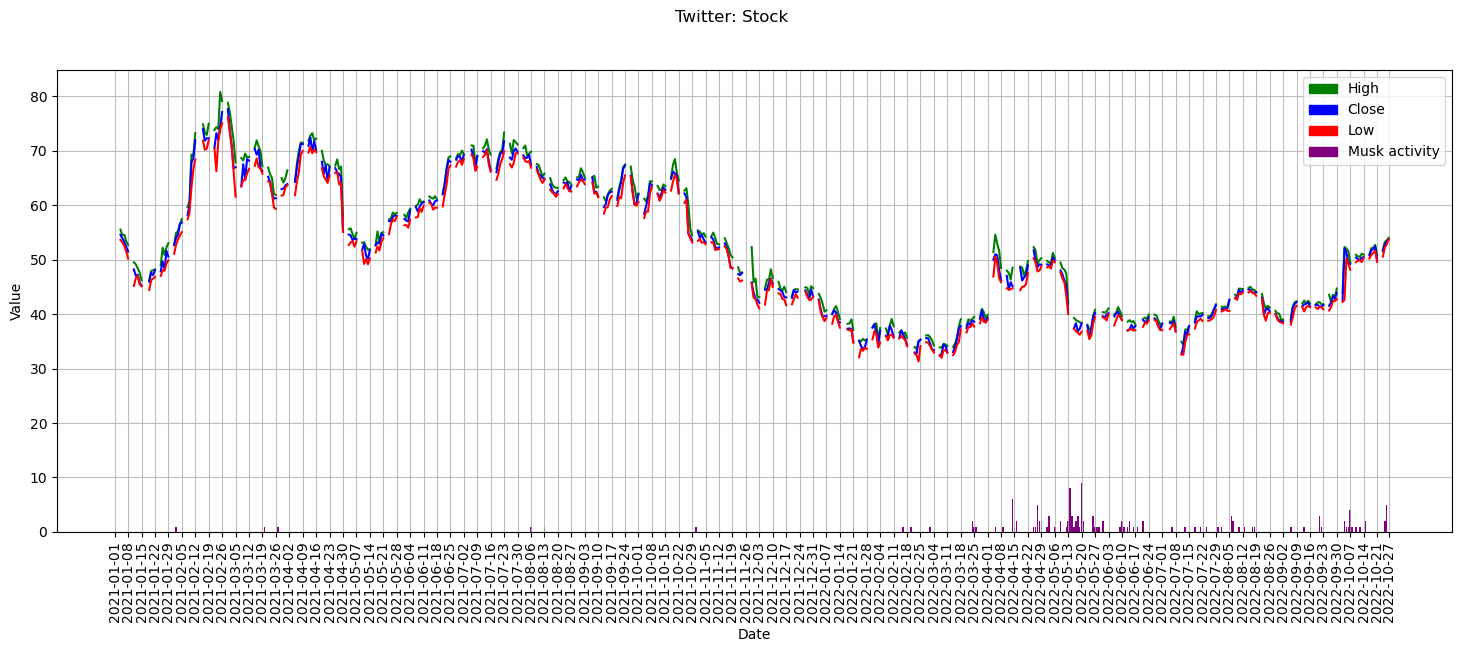

In [20]:
# Plot data
fig, ax = plt.subplots(1, 1, figsize = (18, 6))
fig.suptitle("Twitter: Stock")

plt.bar(df_musk_twitter_activity["Date_day"], df_musk_twitter_activity["Tweets"], color='purple')
plt.plot(df_twitter_stock["Date_day"], df_twitter_stock["High"], color='green')
plt.plot(df_twitter_stock["Date_day"], df_twitter_stock["Close"], color='blue')
plt.plot(df_twitter_stock["Date_day"], df_twitter_stock["Low"], color='red')
plt.xticks(list(df_twitter_stock.iloc[::7, :]["Date_day"]) 
              + list(df_twitter_stock.loc[df_twitter_stock["Date_day"] == df_twitter_stock["Date_day"].max()]["Date_day"]))

ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.grid(alpha=0.8)

for label in ax.get_xticklabels():
  label.set_rotation(90)

green_patch = mpatches.Patch(color='green', label='High')
blue_patch = mpatches.Patch(color='blue', label='Close')
red_patch = mpatches.Patch(color='red', label='Low')
black_patch = mpatches.Patch(color='purple', label='Musk activity')

plt.legend(handles=[green_patch, blue_patch, red_patch, black_patch ])
plt.show()

### Sentiment Analysis

In [21]:
from torchtext import data
### TODO ...